In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from scipy import stats

import lightgbm as lgb
from catboost import CatBoostRegressor

import math

import matplotlib.pylab as plt
plt.style.use('ggplot')

In [3]:
train_apartment = pd.read_csv('../data/apartments_train.csv')
train_building = pd.read_csv('../data/buildings_train.csv')
train = pd.merge(train_apartment, train_building, left_on='building_id', right_on='id')
train.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
train.drop('id_y', axis=1, inplace=True)

In [4]:
test_apartment = pd.read_csv('../data/apartments_test.csv')
test_building = pd.read_csv('../data/buildings_test.csv')
test = pd.merge(test_apartment, test_building, left_on='building_id', right_on='id')
test.rename(columns={'id_x' : 'id'}, inplace=True)
test.drop('id_y', axis=1, inplace=True)
test = test.drop(['street', 'address'], axis=1)

In [5]:
column_names_apartments = ['apartment_id', 'seller', 'area_total', 'area_kitchen', 'area_living',
       'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared',
       'bathrooms_private', 'windows_court', 'windows_street', 'balconies',
       'loggias', 'condition', 'phones', 'building_id', 'price']
column_names_buildings = ['new', 'latitude', 'longitude', 'district', 'street', 'address',
       'constructed', 'material', 'stories', 'elevator_without',
       'elevator_passenger', 'elevator_service', 'parking', 'garbage_chute',
       'heating']
all_features = column_names_apartments[:-1] + column_names_buildings
#features selected based on gini importance in LGBM model in sequential_all_data
selected_features = ['area_total','area_kitchen','floor','bathrooms_private','longitude','latitude','district','constructed','stories']

In [14]:
def preprocess(data,price_outlier_rejection=False,fill=True):
    if price_outlier_rejection is True:
        data = data[(np.abs(stats.zscore(data['price'])) < 20)]
    if fill is True:
        return data.fillna(data.mean())
    else:
        return data.dropna()

In [7]:
processed_data = preprocess(train)
X = processed_data[selected_features]
y = processed_data['price']

In [8]:
processed_test = preprocess(test)
processed_test = processed_test[selected_features]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model 1

In [10]:
model1 = GradientBoostingRegressor(
    learning_rate=0.01,
    n_estimators=2000,
    subsample=1.0, 
    criterion='friedman_mse', 
    min_samples_split=4, 
    min_samples_leaf=2, 
    min_weight_fraction_leaf=0.0, 
    max_depth=9, 
    min_impurity_decrease=0.0, 
    init=None, 
    random_state=0, 
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0
)

In [11]:
model1.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
gb_prediction = model1.predict(X_test)

In [75]:
gb_mse = math.sqrt(mean_squared_log_error(gb_prediction, y_test))
print('Test MSE:', gb_mse)

Test MSE: 0.17491101246061397


change compared to model in sequential_filtered_data:
criterion = 'friedman_mse' instead of 'mse'
Test MSE is now 0.17491 as compared to 0.12145

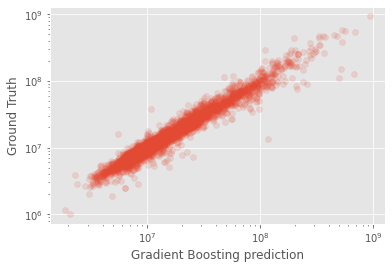

In [76]:
plt.scatter(gb_prediction, y_test, alpha=0.15)
plt.xlabel('Gradient Boosting prediction')
plt.ylabel('Ground Truth')
plt.xscale('log')
plt.yscale('log')

# Model 2
Perform Gradient Boosting in same way as in sequential_filtered_data: but perform price outlier rejection on the training data

In [15]:
select_train = train[selected_features]
X_train, X_test, y_train, y_test = train_test_split(select_train, train['price'], test_size=0.2, random_state=42)
unprocessed = pd.concat([X_train, y_train], axis=1)
print(len(unprocessed))
reject_price_outliers = preprocess(unprocessed,True,True)
print(len(reject_price_outliers))

18628
18624


In [50]:
X_test = preprocess(X_test)

In [41]:
print(len(reject_price_outliers))
print(len(unprocessed))

18493
18628


In [48]:
X_train = reject_price_outliers[selected_features]
y_train = reject_price_outliers['price']
print(len(X_train))
print(len(y_train))

18493
18493


In [46]:
model2 = GradientBoostingRegressor(
    learning_rate=0.01,
    n_estimators=2000,
    subsample=1.0, 
    criterion='mse', 
    min_samples_split=4, 
    min_samples_leaf=2, 
    min_weight_fraction_leaf=0.0, 
    max_depth=9, 
    min_impurity_decrease=0.0, 
    init=None, 
    random_state=0, 
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0
)

In [47]:
model2.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.01, max_depth=9,
                          min_samples_leaf=2, min_samples_split=4,
                          n_estimators=2000, random_state=0)

In [77]:
gb_prediction = model2.predict(X_test)

In [78]:
gb_mse = math.sqrt(mean_squared_log_error(gb_prediction, y_test))
print('Test MSE:', gb_mse)

Test MSE: 0.1655923051689505


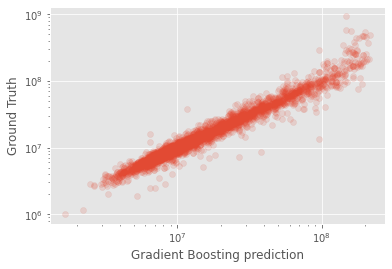

In [79]:
plot = plt.scatter(gb_prediction, y_test, alpha=0.15)
plt.xlabel('Gradient Boosting prediction')
plt.ylabel('Ground Truth')
plt.xscale('log')
plt.yscale('log')

# Tuning  without outlier rejection

learning_rate=0.05,
    n_estimators=2000,
   

In [80]:
train_apartment = pd.read_csv('../data/apartments_train.csv')
train_building = pd.read_csv('../data/buildings_train.csv')
train = pd.merge(train_apartment, train_building, left_on='building_id', right_on='id')
train.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
train.drop('id_y', axis=1, inplace=True)
processed_test = preprocess(test)
processed_test = processed_test[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
model3 = GradientBoostingRegressor(
    learning_rate=0.05,
    n_estimators=2000,
    subsample=1.0, 
    criterion='mse', 
    min_samples_split=4, 
    min_samples_leaf=2, 
    min_weight_fraction_leaf=0.0, 
    max_depth=9, 
    min_impurity_decrease=0.0, 
    init=None, 
    random_state=0, 
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0
)

In [82]:
model3.fit(X_train, y_train)
gb_prediction3 = model3.predict(X_test)

Test MSE: 0.15419014904718775


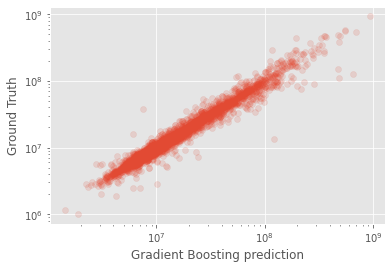

In [83]:
gb_mse3 = math.sqrt(mean_squared_log_error(gb_prediction3, y_test))
print('Test MSE:', gb_mse3)
plot = plt.scatter(gb_prediction3, y_test, alpha=0.15)
plt.xlabel('Gradient Boosting prediction')
plt.ylabel('Ground Truth')
plt.xscale('log')
plt.yscale('log')